[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana10/Hierarchical_Risk_Parity.ipynb)

# Introducción

Critical Line Algorithm (CLA) es un algoritmo para obtener portafolios con mínima varianza sin la necesidad de utilizar programación cuadrática.

Obtenido de 

> David H. Bailey and Marcos Lopez de Prado, "An open-source implementation of the critical line algorithm for portfolio optimization," Algorithms, vol. 6 (2013), pg. 169-196, DOI: 10.3390/a6010169

Se puede encontrar la [publicación](https://ssrn.com/abstract=2197616) y el [código](https://www.davidhbailey.com/dhbpapers/CLA-files.zip) en https://www.davidhbailey.com/dhbpapers/.

In [ ]:
%%writefile CLA.py
#!/usr/bin/env python
# On 20121129
# Critical Line Algorithm
# by MLdP <lopezdeprado@lbl.gov>

import numpy as np
#---------------------------------------------------------------
#---------------------------------------------------------------
class CLA:
    def __init__(self,mean,covar,lB,uB):
        # Initialize the class
        self.mean=mean
        self.covar=covar
        self.lB=lB
        self.uB=uB
        self.w=[] # solution
        self.l=[] # lambdas
        self.g=[] # gammas
        self.f=[] # free weights
#---------------------------------------------------------------
    def solve(self):
        # Compute the turning points,free sets and weights
        f,w=self.initAlgo()
        self.w.append(np.copy(w)) # store solution
        self.l.append(None)
        self.g.append(None)
        self.f.append(f[:])
        while True:
            #1) case a): Bound one free weight
            l_in=None
            if len(f)>1:
                covarF,covarFB,meanF,wB=self.getMatrices(f)
                covarF_inv=np.linalg.inv(covarF)
                j=0
                for i in f:
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,j,[self.lB[i],self.uB[i]])
                    if l_in is None or l>l_in:l_in,i_in,bi_in=l,i,bi
                    j+=1
            #2) case b): Free one bounded weight
            l_out=None
            if len(f)<self.mean.shape[0]:
                b=self.getB(f)
                for i in b:
                    covarF,covarFB,meanF,wB=self.getMatrices(f+[i])
                    covarF_inv=np.linalg.inv(covarF)
                    l,bi=self.computeLambda(covarF_inv,covarFB,meanF,wB,meanF.shape[0]-1, \
                        self.w[-1][i])
                    if (self.l[-1]==None or l<self.l[-1]) and (l_out is None or l>l_out):
                        l_out,i_out=l,i                
            #3) decide lambda
            if (l_in==None or l_in<0) and (l_out==None or l_out<0):break
            if l_in is not None and (l_out is None or l_in > l_out):
                self.l.append(l_in)
                f.remove(i_in)
                w[i_in]=bi_in # set value at the correct boundary
            else:
                self.l.append(l_out)
                f.append(i_out)
            #4) compute solution vector
            covarF,covarFB,meanF,wB=self.getMatrices(f)
            covarF_inv=np.linalg.inv(covarF)
            wF,g=self.computeW(covarF_inv,covarFB,meanF,wB)
            for i in range(len(f)):w[f[i]]=wF[i]
            self.w.append(np.copy(w)) # store solution
            self.g.append(g)
            self.f.append(f[:])
            if len(f)==self.mean.shape[0]:
                #5) minimum variance solution
                wF,g=self.computeW(covarF_inv,covarFB,np.zeros(meanF.shape),wB)
                for i in range(len(f)):w[f[i]]=wF[i]
                self.w.append(np.copy(w)) # store solution
                self.g.append(g)
                self.f.append(f[:])
#---------------------------------------------------------------    
    def initAlgo(self):
        # Initialize the algo
        #1) Form structured array
        a=np.zeros((self.mean.shape[0]),dtype=[('id',int),('mu',float)])
        b=[self.mean[i][0] for i in range(self.mean.shape[0])] # dump array into list
        a[:]=list(zip(range(self.mean.shape[0]),b)) # fill structured array
        #2) Sort structured array
        b=np.sort(a,order='mu')
        #3) First free weight
        i,w=b.shape[0],np.copy(self.lB)
        while sum(w)<1:
            i-=1
            w[b[i][0]]=self.uB[b[i][0]]
        w[b[i][0]]+=1-sum(w)
        return [b[i][0]],w
#---------------------------------------------------------------    
    def computeBi(self,c,bi):
        if c>0:
            bi=bi[1]
        if c<0:
            bi=bi[0]
        return bi
#---------------------------------------------------------------
    def computeW(self,covarF_inv,covarFB,meanF,wB):
        #1) compute gamma
        onesF=np.ones(meanF.shape)
        g1=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        g2=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        if np.all(wB)==None:
            g,w1=float(-self.l[-1]*g1/g2+1/g2),0
        else:
            onesB=np.ones(wB.shape)
            g3=np.dot(onesB.T,wB)
            g4=np.dot(covarF_inv,covarFB)
            w1=np.dot(g4,wB)
            g4=np.dot(onesF.T,w1)
            g=float(-self.l[-1]*g1/g2+(1-g3+g4)/g2)
        #2) compute weights
        w2=np.dot(covarF_inv,onesF)
        w3=np.dot(covarF_inv,meanF)
        return -w1+g*w2+self.l[-1]*w3,g
#---------------------------------------------------------------
    def computeLambda(self,covarF_inv,covarFB,meanF,wB,i,bi):
        #1) C
        onesF=np.ones(meanF.shape)
        c1=np.dot(np.dot(onesF.T,covarF_inv),onesF)
        c2=np.dot(covarF_inv,meanF)
        c3=np.dot(np.dot(onesF.T,covarF_inv),meanF)
        c4=np.dot(covarF_inv,onesF)
        c=-c1*c2[i]+c3*c4[i]
        if c==0:return
        #2) bi
        if type(bi)==list:bi=self.computeBi(c,bi)
        #3) Lambda
        if np.all(wB==None):
            # All free assets
            return float((c4[i]-c1*bi)/c),bi
        else:
            onesB=np.ones(wB.shape)
            l1=np.dot(onesB.T,wB)
            l2=np.dot(covarF_inv,covarFB)
            l3=np.dot(l2,wB)
            l2=np.dot(onesF.T,l3)
            return float(((1-l1+l2)*c4[i]-c1*(bi+l3[i]))/c),bi
#---------------------------------------------------------------
    def getMatrices(self,f):
        # Slice covarF,covarFB,covarB,meanF,meanB,wF,wB
        covarF=self.reduceMatrix(self.covar,f,f)
        meanF=self.reduceMatrix(self.mean,f,[0])
        b=self.getB(f)
        covarFB=self.reduceMatrix(self.covar,f,b)
        wB=self.reduceMatrix(self.w[-1],b,[0])
        return covarF,covarFB,meanF,wB
#---------------------------------------------------------------
    def getB(self,f):
        return self.diffLists(range(self.mean.shape[0]),f)
#---------------------------------------------------------------
    def diffLists(self,list1,list2):
        return list(set(list1)-set(list2))
#---------------------------------------------------------------
    def reduceMatrix(self,matrix,listX,listY):
        matrix = np.array(matrix)
        # Reduce a matrix to the provided list of rows and columns
        if len(listX)==0 or len(listY)==0:return
        matrix_=matrix[:,listY[0]:listY[0]+1]
        for i in listY[1:]:
            a=matrix[:,i:i+1]
            matrix_=np.append(matrix_,a,1)
        matrix__=matrix_[listX[0]:listX[0]+1,:]
        for i in listX[1:]:
            a=matrix_[i:i+1,:]
            matrix__=np.append(matrix__,a,0)
        return matrix__
#---------------------------------------------------------------
    def getMinVar(self):
        # Get the minimum variance solution
        var=[]
        for w in self.w:
            a=np.dot(np.dot(w.T,self.covar),w)
            var.append(a)
        return min(var)**.5,self.w[var.index(min(var))]
#---------------------------------------------------------------
    def getMaxSR(self):
        # Get the max Sharpe ratio portfolio
        #1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr,sr=[],[]
        for i in range(len(self.w)-1):
            w0=np.copy(self.w[i])
            w1=np.copy(self.w[i+1])
            kargs={'minimum':False,'args':(w0,w1)}
            a,b=self.goldenSection(self.evalSR,0,1,**kargs)
            w_sr.append(a*w0+(1-a)*w1)
            sr.append(b)
        return max(sr),w_sr[sr.index(max(sr))]
#---------------------------------------------------------------
    def evalSR(self,a,w0,w1):
        # Evaluate SR of the portfolio within the convex combination
        w=a*w0+(1-a)*w1
        b=np.dot(w.T,self.mean)[0,0]
        c=np.dot(np.dot(w.T,self.covar),w)[0,0]**.5
        return b/c
#---------------------------------------------------------------
    def goldenSection(self,obj,a,b,**kargs):
        # Golden section method. Maximum if kargs['minimum']==False is passed 
        from math import log,ceil
        tol,sign,args=1.0e-9,1,None
        if 'minimum' in kargs and kargs['minimum']==False:sign=-1
        if 'args' in kargs:args=kargs['args']
        numIter=int(ceil(-2.078087*log(tol/abs(b-a))))
        r=0.618033989
        c=1.0-r
        # Initialize
        x1=r*a+c*b;x2=c*a+r*b
        f1=sign*obj(x1,*args);f2=sign*obj(x2,*args)
        # Loop
        for i in range(numIter):
            if f1>f2:
                a=x1
                x1=x2;f1=f2
                x2=c*a+r*b;f2=sign*obj(x2,*args)
            else:
                b=x2
                x2=x1;f2=f1
                x1=r*a+c*b;f1=sign*obj(x1,*args)
        if f1<f2:return x1,sign*f1
        else:return x2,sign*f2
#---------------------------------------------------------------
    def efFrontier(self,points):
        # Get the efficient frontier
        mu,sigma,weights=[],[],[]
        a=np.linspace(0,1,points/len(self.w))[:-1] # remove the 1, to avoid duplications
        b=range(len(self.w)-1)
        for i in b:
            w0,w1=self.w[i],self.w[i+1]
            if i==b[-1]:a=np.linspace(0,1,points/len(self.w)) # include the 1 in the last iteration
            for j in a:
                w=w1*j+(1-j)*w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T,self.mean)[0,0])
                sigma.append(np.dot(np.dot(w.T,self.covar),w)[0,0]**.5)
        return mu,sigma,weights
#---------------------------------------------------------------
#---------------------------------------------------------------

Writing CLA.py


# Dependencia

In [ ]:
!pip install -U scipy yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 6.4 MB 25.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
d

In [ ]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

import random
import numpy as np
import pandas as pd

import yfinance as yf

from scipy.spatial.distance import squareform

from CLA import CLA

# Bases de HRP

El algoritmo consta de 3 grandes pasos:

- Hierarchical Tree Clustering

- Matrix Seriation

- Recursive Bisection

# Funciones

La siguiente función nos crea un portafolio en que los pesos asignados a cada activo se toman como valores inversos a sus varianzas (inversiones mas seguras)

In [ ]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp = 1./np.diag(cov)
    ivp /= ivp.sum()
    return ivp

In [ ]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems,cItems] # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)
    cVar = np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

La siguiente función sirve para reorganizar las filas y las columnas de la matriz de covarianzas para que los valores más grandes se queden alrededos de la diagonal. Esta tiene un propiedad útil: Inversiones similares son posicionadas juntas y distintos son puestos lejos unos de otros.

In [ ]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1,0],link[-1,1]])
    numItems = link[-1,3] # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0,sortIx.shape[0]*2,2) # make space
        df0 = sortIx[sortIx >= numItems] # find clusters
        i = df0.index;j = df0.values-numItems
        sortIx[i] = link[j,0] # item 1
        df0 = pd.Series(link[j,1],index = i+1)
        sortIx = sortIx.append(df0) # item 2
        sortIx = sortIx.sort_index() # re-sort
        sortIx.index = range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

La siguiente función regresa los pesos del portafolio de acuerdo al agoritmo de HRP:

Para crear los pesos, se usa la "inverse-variance allocation", el algoritmo es el siguiente:

1. El algoritmo se inicializa:
  
  a. Creando una lista de objetos: $L = \left\{ L_0 \right\}$ con $L_0 = \left\{ n\right\}_{n=1, \dots, N}$

  b. Asignando un peso unitario a todos los objetos: $w_n = 1$, $\forall n = 1, \dots, N$

2. Si $\|L_i\| = 1$, $\forall L_i \in L$ detenerse.
3. Para cada $L_i \in L$ tal que $\|L_i\| > 1$:

  a. bisectar $L_i$ en dos subconjuntos, $L_i^{(1)} \cup L_i^{(2)} = L_i$, donde $\|L_i^{(1)}\| = int\left[ \frac{1}{2}\|L_i\| \right]$, y el orden es preservado

  b. define la variance de $L_i^{(j)}$, $j = 1, 2$ como la forma cuadrática $\tilde{V}_i^{(j)} \equiv \tilde{w}_i^{(j)^{T}} V_i^{(j)} \tilde{w}_i^{(j)}$, donde $V_i^{(j)}$ es la matriz de covarianza entre los que conforman la bisección $L_i^{(j)}$, y $\tilde{w}_i^{(j)} = diag\left[ V_i^{(j)}\right] ^ {-1} \frac{1}{tr\left[ diag\left[ V_i^{(j)}\right] \right]}$, donde $diag\left[ . \right]$ y $tr \left[ . \right]$ son los operadores diagonal y traza.
  
  c. Calcula el factor de división: $\alpha_i = 1 - \frac{\tilde{V}_i^{(1)}}{\tilde{V}_i^{(1)}+\tilde{V}_i^{(2)}}$, tal que $0 \leq \alpha_i \leq 1$

  d. re-escala los pesos por un factor de $\alpha_i$, $\forall n \in L_i^{(1)}$

  re-escala los pesos por un factor de $\left(1 - \alpha_i \right)$, $\forall n \in L_i^{(1)}$

4. Repite desde el paso 2.

In [ ]:
def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1,index = sortIx)
    cItems = [sortIx] # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [
                  i[j:k] 
                  for i in cItems 
                  for j, k in ((0, int(len(i)/2)), (int(len(i)/2), len(i))) 
                  if len(i) > 1
        ] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0 = cItems[i] # cluster 1
            cItems1 = cItems[i+1] # cluster 2
            cVar0 = getClusterVar(cov,cItems0)
            cVar1 = getClusterVar(cov,cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha # weight 1
            w[cItems1] *= 1-alpha # weight 2
    return w

In [ ]:
def getCLA(cov,**kargs):
    # Compute CLA's minimum variance portfolio
    mean = np.arange(cov.shape[0]).reshape(-1,1) # Not used by C portf
    lB = np.zeros(mean.shape)
    uB = np.ones(mean.shape)
    cla = CLA(mean,cov,lB,uB)
    cla.solve()
    return cla.w[-1].flatten()

In [ ]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0< = d[i,j]< = 1
    # This is a proper distance metric
    dist = ((1-corr)/2.)**.5 # distance matrix
    return squareform(dist)

In [ ]:
def plotCorrMatrix(path,corr,labels = None):
    # Heatmap of the correlation matrix
    if labels is None:labels = []
    plt.pcolor(corr)
    plt.colorbar()
    plt.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    plt.savefig(path)
    plt.clf();plt.close() # reset pylab
    return

In [ ]:
#NO CORRER (datos de prueba solamente)


def generateData(nObs,size0,size1,sigma1):
    # Time series of correlated variables
    #1) generating some uncorrelated data
    np.random.seed(seed = 12345); random.seed(12345)
    x = np.random.normal(0, 1, size = (nObs,size0)) # each row is a variable
    #2) creating correlation between the variables
    cols = [random.randint(0, size0 - 1) for i in range(size1)]
    y = x[:,cols]+np.random.normal(0, sigma1, size = (nObs, len(cols)))
    x = np.append(x, y, axis = 1)
    x = pd.DataFrame(x, columns = range(1, x.shape[1] + 1))
    return x, cols

In [ ]:
def get_allocations(x, return_linkage = False):
    #1) Load the data
    cov, corr = x.cov(), x.corr()
    #2) compute and plot correl matrix
    plotCorrMatrix('HRP3_corr0.png',corr,labels = corr.columns)
    #3) cluster
    dist = correlDist(corr)
    link = sch.linkage(dist,'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist() # recover labels
    df0 = corr.loc[sortIx,sortIx] # reorder
    plotCorrMatrix('HRP3_corr1.png',df0,labels = df0.columns)
    #4) Capital allocation
    hrp = getRecBipart(cov,sortIx)
    allocation = hrp.to_frame(name = 'HRP').sort_index()
    allocation['CLA'] = np.round(getCLA(cov), 6)
    if return_linkage:
        return allocation, link
    return allocation

# Datos

In [ ]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        # tickers = "GOOG AAPL IBM MSFT FB NFLX AMZN PLTR FSLY NET DDOG ZS SNOW",
        tickers = "AAPL IBM MSFT PLTR FSLY NET DDOG ZS SNOW",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "1y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close'].dropna()
data

[*********************100%***********************]  9 of 9 completed


,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-05-27,124.568314,92.309998,48.230000,130.955170,247.290756,82.809998,22.700001,245.149994,194.259995
2021-05-28,123.902122,91.050003,47.189999,130.882324,247.657730,82.059998,22.950001,238.029999,194.199997
2021-06-01,123.573997,91.879997,47.290001,131.292068,245.396210,83.070000,23.059999,240.809998,191.770004
2021-06-02,124.349556,91.599998,48.770000,132.685196,245.297012,83.860001,24.450001,243.179993,191.339996
2021-06-03,122.838203,88.690002,47.619999,132.530411,243.719925,81.919998,23.629999,238.429993,184.250000
...,...,...,...,...,...,...,...,...,...
2022-05-20,137.589996,94.790001,11.930000,128.479996,252.559998,55.689999,8.080000,141.490005,136.889999
2022-05-23,143.110001,93.930000,11.850000,131.169998,260.649994,56.750000,8.010000,138.850006,138.169998
2022-05-24,140.360001,85.809998,10.710000,133.800003,259.619995,50.500000,7.550000,129.630005,127.809998


# Rendimientos

In [ ]:
x = np.log(data / data.shift()) / (1 / 252) # Para anualizar los retornos
x.dropna(inplace = True)
x

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-05-28,-1.351312,-3.463390,-5.493410,-0.140217,0.373685,-2.292731,2.760159,-7.427330,-0.077843
2021-06-01,-0.668247,2.286776,0.533459,0.787687,-2.311744,3.082707,1.204944,2.926103,-3.173129
2021-06-02,1.576626,-0.769127,7.765759,2.659861,-0.101887,2.385212,14.749750,2.468000,-0.565697
2021-06-03,-3.081589,-8.135589,-6.013365,-0.294145,-1.625414,-5.898214,-8.596524,-4.970988,-9.515117
2021-06-04,4.748560,-0.682866,-1.645837,3.217060,5.156879,3.543342,4.230078,4.327686,2.111083
...,...,...,...,...,...,...,...,...,...
2022-05-20,0.439933,-4.570809,-3.981779,-2.303898,-0.578052,-10.241894,-7.073085,-9.318535,8.594607
2022-05-23,9.912508,-2.296753,-1.695547,5.221682,7.945473,4.751481,-2.192671,-4.746376,2.345394
2022-05-24,-4.889560,-22.784405,-25.489803,5.002702,-0.997790,-29.403945,-14.904087,-17.314915,-19.640888


# Portafolios

{'color_list': ['C1', 'C2', 'C2', 'C2', 'C2', 'C2', 'C0', 'C0'],
 'dcoord': [[0.0, 0.3514689491335886, 0.3514689491335886, 0.0],
  [0.0, 0.32451360035650695, 0.32451360035650695, 0.0],
  [0.0, 0.3498243420933926, 0.3498243420933926, 0.0],
  [0.32451360035650695,
   0.3504066375676848,
   0.3504066375676848,
   0.3498243420933926],
  [0.0, 0.36796429081536225, 0.36796429081536225, 0.0],
  [0.3504066375676848,
   0.38686383711453476,
   0.38686383711453476,
   0.36796429081536225],
  [0.3514689491335886,
   0.4378944832207031,
   0.4378944832207031,
   0.38686383711453476],
  [0.0, 0.6060154562606916, 0.6060154562606916, 0.4378944832207031]],
 'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [55.0, 55.0, 65.0, 65.0],
  [40.0, 40.0, 60.0, 60.0],
  [75.0, 75.0, 85.0, 85.0],
  [50.0, 50.0, 80.0, 80.0],
  [20.0, 20.0, 65.0, 65.0],
  [5.0, 5.0, 42.5, 42.5]],
 'ivl': ['3', '0', '4', '5', '8', '1', '7', '2', '6'],
 'leaves': [3, 0, 4, 5, 8, 1, 7, 2, 6],
 'leaves_color_list': [

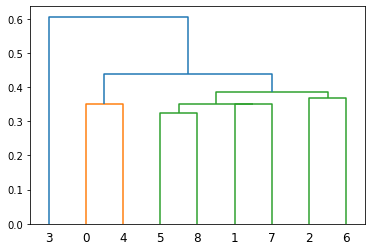

In [ ]:
allocation, linkage = get_allocations(x, True)
sch.dendrogram(linkage)

In [ ]:
allocation

,HRP,CLA
AAPL,0.245293,0.000000
DDOG,0.028879,0.000000
FSLY,0.009804,0.000000
IBM,0.370277,0.595852
MSFT,0.245909,0.404148
NET,0.027036,0.000000
PLTR,0.015818,0.000000
SNOW,0.027064,0.000000
ZS,0.029922,0.000000


In [ ]:
start = 0
end = 24

data_weekly = [g[1] for g in list(data.groupby(pd.Grouper(freq = 'W')))]
print(len(data_weekly))
data_weekly[0]

53


,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-05-27,124.568314,92.309998,48.230000,130.955170,247.290756,82.809998,22.700001,245.149994,194.259995
2021-05-28,123.902122,91.050003,47.189999,130.882324,247.657730,82.059998,22.950001,238.029999,194.199997


In [ ]:
portfolio_data = pd.concat(data_weekly[start:end])
portfolio_data

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-05-27,124.568314,92.309998,48.230000,130.955170,247.290756,82.809998,22.700001,245.149994,194.259995
2021-05-28,123.902122,91.050003,47.189999,130.882324,247.657730,82.059998,22.950001,238.029999,194.199997
2021-06-01,123.573997,91.879997,47.290001,131.292068,245.396210,83.070000,23.059999,240.809998,191.770004
2021-06-02,124.349556,91.599998,48.770000,132.685196,245.297012,83.860001,24.450001,243.179993,191.339996
2021-06-03,122.838203,88.690002,47.619999,132.530411,243.719925,81.919998,23.629999,238.429993,184.250000
...,...,...,...,...,...,...,...,...,...
2021-11-01,148.335709,165.199997,51.500000,116.307922,327.327728,194.259995,26.559999,357.730011,318.679993
2021-11-02,149.391266,164.880005,49.320000,116.215828,331.064423,192.369995,25.920000,359.640015,325.869995
2021-11-03,150.855118,162.789993,53.320000,117.090805,331.929016,194.850006,26.120001,353.140015,327.500000


In [ ]:
x = np.log(portfolio_data / portfolio_data.shift()) / (1 / 252) # Para anualizar los retornos
x.dropna(inplace = True)
x

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-05-28,-1.351312,-3.463390,-5.493410,-0.140217,0.373685,-2.292731,2.760159,-7.427330,-0.077843
2021-06-01,-0.668247,2.286776,0.533459,0.787687,-2.311744,3.082707,1.204944,2.926103,-3.173129
2021-06-02,1.576626,-0.769127,7.765759,2.659861,-0.101887,2.385212,14.749750,2.468000,-0.565697
2021-06-03,-3.081589,-8.135589,-6.013365,-0.294145,-1.625414,-5.898214,-8.596524,-4.970988,-9.515117
2021-06-04,4.748560,-0.682866,-1.645837,3.217060,5.156879,3.543342,4.230078,4.327686,2.111083
...,...,...,...,...,...,...,...,...,...
2021-11-01,-1.417073,-2.806359,4.393018,2.365832,-1.715619,-0.596029,6.535839,2.755297,-0.142291
2021-11-02,1.786882,-0.488597,-10.899538,-0.199617,2.860475,-2.463770,-6.146640,1.341907,5.622390
2021-11-03,2.457273,-3.214759,19.651418,1.890176,0.657254,3.227991,1.936988,-4.596216,1.257364


In [ ]:
allocations = get_allocations(x)
allocations

,HRP,CLA
AAPL,0.255819,0.099968
DDOG,0.041912,0.000000
FSLY,0.012380,0.012865
IBM,0.186691,0.339053
MSFT,0.299158,0.413784
NET,0.035090,0.000000
PLTR,0.019911,0.003482
SNOW,0.073311,0.041354
ZS,0.075729,0.089493


In [ ]:
start_price = data_weekly[end-1].iloc[-1, :]
end_price = data_weekly[end].iloc[-1, :]
change = end_price - start_price
change

AAPL    -1.286453
DDOG     7.520004
FSLY     0.820000
IBM     -2.950485
MSFT     0.655914
NET      7.500000
PLTR    -3.170000
SNOW    21.700012
ZS      10.580017
dtype: float64

In [ ]:
allocations.mul(change, 0)

,HRP,CLA
AAPL,-0.329100,-0.128604
DDOG,0.315178,0.000000
FSLY,0.010152,0.010549
IBM,-0.550828,-1.000371
MSFT,0.196222,0.271407
NET,0.263173,0.000000
PLTR,-0.063117,-0.011038
SNOW,1.590840,0.897382
ZS,0.801209,0.946837


In [ ]:
allocations.mul(change, 0).sum()

HRP    2.233730
CLA    0.986163
dtype: float64

# Comparación

In [ ]:
start = 0
end = 24

periods_ = range(len(data_weekly) - end)
earnings = np.zeros((len(periods_), 2))
alloc_list = []

for i in periods_:
    portfolio_data = pd.concat(data_weekly[start:end])

    x = np.log(portfolio_data / portfolio_data.shift(periods=5)) # / (1 / 252) # Para anualizar los retornos
    x.dropna(inplace = True)

    allocations = get_allocations(x)
    alloc_list.append(allocations)

    start_price = data_weekly[end-1].iloc[-1, :]
    end_price = data_weekly[end].iloc[-1, :]
    change = end_price - start_price

    earnings[i, :] = allocations.mul(change, 0).sum()

    start += 1
    end += 1

In [ ]:
alloc_list[20]

,HRP,CLA
AAPL,0.148431,0.000000
DDOG,0.036928,0.000000
FSLY,0.021655,0.000000
IBM,0.445228,0.507847
MSFT,0.173741,0.492153
NET,0.037342,0.000000
PLTR,0.059812,0.000000
SNOW,0.032490,0.000000
ZS,0.044374,0.000000


In [ ]:
earnings = pd.DataFrame(earnings, columns = ['HRP', 'CLA'])

In [ ]:
import plotly.express as px
fig = px.line(earnings.cumsum(), markers = True)
fig.update_layout(hovermode = 'x')
fig.show()

In [ ]:
data_weekly[0]

,AAPL,DDOG,FSLY,IBM,MSFT,NET,PLTR,SNOW,ZS
Date,,,,,,,,,
2021-05-27,124.568314,92.309998,48.230000,130.955170,247.290756,82.809998,22.700001,245.149994,194.259995
2021-05-28,123.902122,91.050003,47.189999,130.882324,247.657730,82.059998,22.950001,238.029999,194.199997


In [ ]:
alloc_list[0]

,HRP,CLA
AAPL,0.373577,0.162980
DDOG,0.074555,0.011149
FSLY,0.015072,0.000000
IBM,0.210146,0.312727
MSFT,0.188769,0.408349
NET,0.010015,0.000000
PLTR,0.040591,0.022317
SNOW,0.057213,0.049449
ZS,0.030063,0.000000


In [ ]:
px.line(data)